In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import yfinance as yf
import datetime as dt
import mpmath
from scipy.integrate import quad

In [2]:
end = pd.to_datetime('today')
start = pd.to_datetime('1 jan 2023')

data_history = yf.download('^SPX', start=start, end=end)
S0=data_history.Close[-1]

[*********************100%***********************]  1 of 1 completed


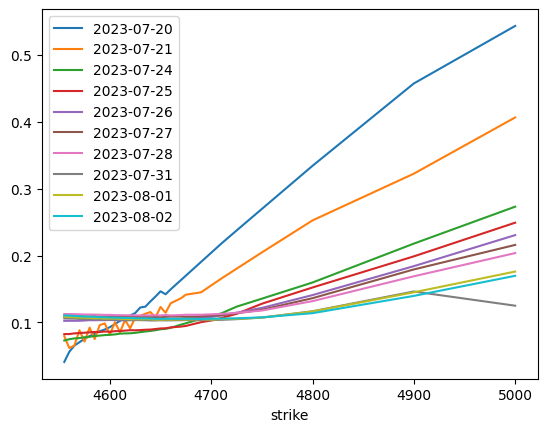

In [3]:
SPX = yf.Ticker("^SPX")
timeRange = pd.date_range(pd.to_datetime('today'), periods=10, freq='B')

implied_vol = [SPX.option_chain(i.strftime("%Y-%m-%d"))[0].set_index('strike')\
               ['impliedVolatility'] for i in timeRange]

implied_vol = pd.concat(implied_vol, axis=1).dropna()
implied_vol = implied_vol[implied_vol.index>4000]
implied_vol = implied_vol[implied_vol.impliedVolatility>0.00002].dropna()

implied_vol.columns= [i.strftime("%Y-%m-%d") for i in timeRange]

implied_vol.plot()

option_price = [SPX.option_chain(i.strftime("%Y-%m-%d"))[0].set_index('strike')\
               ['lastPrice'] for i in timeRange]

option_price = pd.concat(option_price, axis=1).dropna()
option_price = option_price[option_price.index>4000]

option_price.columns= [i.strftime("%Y-%m-%d") for i in timeRange]


# Heston Model:

## under risk-neutral measure:
$$
dS_t= r S_t dt+\sqrt{v_t}S_t dW_{1,t}^\mathbb{Q}
\\
dv_t=\kappa(\theta-v_t)dt+\sigma\sqrt{v_t}dW_{2,t}^\mathbb{Q}
\\
dW_{1,t}^\mathbb{Q}dW_{2,t}^\mathbb{Q}=\rho dt
$$

In [4]:
def heston_charfunc_quantpy(phi, S0, v0, kappa, theta, sigma, rho, tau, r):
    
    # constants
    b = kappa
    a = theta*kappa
    
    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )
    
    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)
    
    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
    return exp1*term2*exp2  

def heston_charfunc_QFwP(phi, S0, v0, kappa, theta, sigma, rho, tau, r):
    
    kappaQ = kappa
    thetaQ = theta
    
    rspi = rho*sigma*phi*1j
    xi = np.sqrt(sigma**2*(phi**2+1j*phi)+(kappaQ-rspi)**2)
    
    wphi = np.exp(1j*phi*np.log(S0)+1j*phi*(r)*tau+kappaQ*thetaQ*tau*(kappaQ-rspi)/sigma**2)\
                  /(np.cosh(xi*tau/2)+(kappaQ-rspi)/xi*np.sinh(xi*tau/2))
    
    return wphi*np.exp(-(phi**2+1j*phi)*v0/(xi/np.tanh(0.5*xi*tau)+kappaQ-rspi))

## Call price using mixed FFT and Quadrature

In [5]:
def integrand_QFwP(phi,K, alpha, S0, v0, kappa, theta, sigma, rho, tau, r):
    args = ( S0, v0, kappa, theta, sigma, rho, tau, r)
    psi = heston_charfunc_QFwP(phi-(alpha+1)*1j, *args)/np.exp(r*tau)/(alpha+1j*phi)/(alpha+1j*phi+1)
    return psi*np.exp(-1j*phi*np.log(K))
    
    
def heston_call_price_QFwP(K,alpha, S0, v0, kappa, theta, sigma, rho, tau, r):
    args = (K,alpha,S0, v0, kappa, theta, sigma, rho, tau, r)
    
    integral, err = quad(integrand_QFwP, 0, 1, args=args)
    return np.exp(-alpha*np.log(K))/np.pi*integral
    

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


<AxesSubplot:>

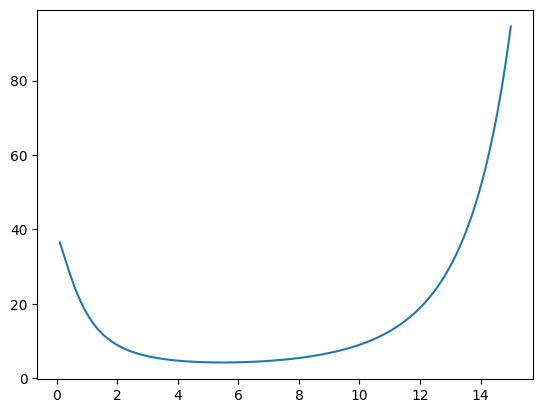

In [6]:
# Parameters to test model
alpha = np.linspace(0.1,15,200) # damping parameter
S0 = 100. # initial asset price
K = 100. # strike
v0 = 0.1 # initial variance
r = 0.03 # risk free rate
kappa = 1.5768 # rate of mean reversion of variance process
theta = 0.0398 # long-term mean variance
sigma = 0.3 # volatility of volatility
rho = -0.5711 # correlation between variance and stock process
tau = 1. # time to maturity

prices=[heston_call_price_QFwP(K,i, S0, v0, kappa, theta, sigma, rho, tau, r) for i in alpha]
df = pd.DataFrame(data = prices, 
                  index = alpha)
df.plot(legend=0)

In [7]:
heston_call_price_QFwP(K,1, S0, v0, kappa, theta, sigma, rho, tau, r)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


17.25549615530696

## Call price using Quantpy

In [8]:
def integrand_quantpy(phi, S0, v0, kappa, theta, sigma, rho, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc_QFwP(phi-1j,*args) - K*heston_charfunc_QFwP(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

def heston_price_quantpy(S0, K, v0, kappa, theta, sigma, rho, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, tau, r)
    
    real_integral, err = np.real( quad(integrand_quantpy, 0, 100, args=args) )
    
    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

In [9]:
# Parameters to test model
S0 = 100. # initial asset price
K = 100. # strike
v0 = 0.1 # initial variance
r = 0.03 # risk free rate
kappa = 1.5768 # rate of mean reversion of variance process
theta = 0.0398 # long-term mean variance
sigma = 0.3 # volatility of volatility
rho = -0.5711 # correlation between variance and stock process
tau = 1. # time to maturity
heston_price_quantpy( S0, K, v0, kappa, theta, sigma, rho, tau, r )

16.88837647928907

## Call price using Monte-Carlo

In [14]:
def heston_model_sims(S0, v0, kappa, theta, sigma, rho, tau, r, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - tau     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    
    kappaQ = kappa
    thetaQ = theta
    
    dt = tau/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)
    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

def heston_price_MC(S0, K, v0, kappa, theta, sigma, rho, tau, r):
    N = 1000
    M = 1000 
    S,v = heston_model_sims(S0, v0, kappa, theta, sigma, rho, tau, r, N, M)
    payoff = np.array([np.exp(-r*tau)*np.maximum(i-K,0) for i in S])
    
    return payoff.mean(),payoff.std()/np.sqrt(M)

In [17]:
# Parameters to test model
S0 = 100. # initial asset price
K = 100. # strike
v0 = 0.1 # initial variance
r = 0.03 # risk free rate
kappa = 1.5768 # rate of mean reversion of variance process
theta = 0.0398 # long-term mean variance
sigma = 0.3 # volatility of volatility
rho = -0.5711 # correlation between variance and stock process
tau = 1. # time to maturity
heston_price_MC( S0, K, v0, kappa, theta, sigma, rho, tau, r )

(7.753830965173885, 0.385717831770319)